

# BABY CRYING CLASSIFICATION using DEEP LEARNING with Keras (MLP, RNN, CNN)

### Objective

Baby crying translator using deep learning algorithms. 


### Data

My own baby's cries dataset (50 .wav audios)


In [1]:
##Ana
from google.colab import drive
drive.mount('/content/drive')

!pwd
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content
drive  sample_data


To load the audio files into the jupyter notebook ass a numpy array I have used 'librosa' library in python by using the pip command as follows

 ***pip install librosa***

In [2]:
! python -m pip install librosa

    100% |████████████████████████████████| 1.6MB 8.3MB/s 
    100% |████████████████████████████████| 327kB 23.5MB/s 
    100% |████████████████████████████████| 3.2MB 6.9MB/s 
    100% |████████████████████████████████| 16.1MB 1.1MB/s 
  Running setup.py bdist_wheel for librosa ... - \ done
  Stored in directory: /root/.cache/pip/wheels/18/b8/10/f0f8f6ac60668a5cd75596cf14c25bb6b3ea1ecd815f058b7e
  Running setup.py bdist_wheel for audioread ... - done
  Stored in directory: /root/.cache/pip/wheels/53/02/90/7b5c4081b7470c550ab605f600bad237dde12a6b8999b11f50
  Running setup.py bdist_wheel for resampy ... - done
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built librosa audioread resampy


In [3]:
import os
import pandas as pd
import librosa
import librosa.display
import glob
% pylab inline
from sklearn.preprocessing import LabelEncoder
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from sklearn import metrics 
import os
#print(os.listdir("../input"))

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [4]:
import IPython.display as ipd
ipd.Audio('drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/train/Train/170218125549hambre-1-0-0.wav')

Now let us load a sample audio file using librosa

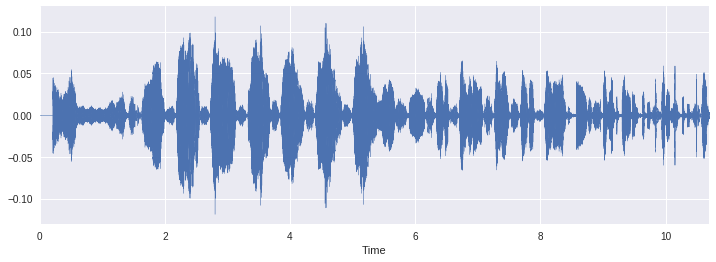

In [149]:
data,sample_rate = librosa.load('drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/train/Train/170218125549hambre-1-0-0.wav')
plt.figure(figsize=(12,4))
librosa.display.waveplot(data,sr=sample_rate)

In [0]:
data,sample_rate = librosa.load('drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/train/Train/170218125549hambre-1-0-0.wav')
plt.figure(figsize=(12,4))
librosa.display.waveplot(data,sr=sample_rate)

Now let us visually inspect data by selecting a random noise and see if we can find patterns in the data

('ID: ', 3)
('Class: ', 'hambre')


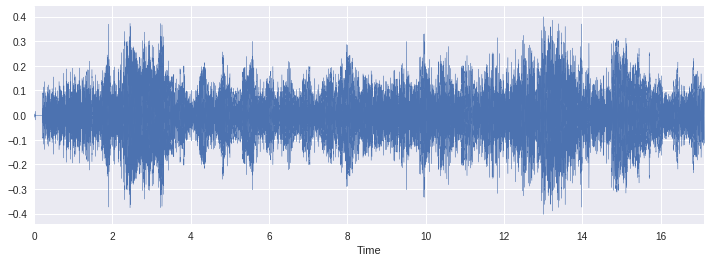

In [6]:
train = pd.read_csv('drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/train/train.csv')
i = random.choice(train.index) 
audio_name = train.ID[i]

path = os.path.join('drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/train/', 'Train', str(audio_name) + '.wav')

print('ID: ', i)
print('Class: ', train.Class[i])

x, sr = librosa.load('drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/train/Train/' + str(train.ID[i]) + '.wav')

plt.figure(figsize=(12, 4))

librosa.display.waveplot(x, sr=sr)

As you can see the air conditioner class is shown as random class and we can see its pattern.Let us again see another class by using the same code to randomly select another class and observe its pattern

('Class: ', 'no_hambre')


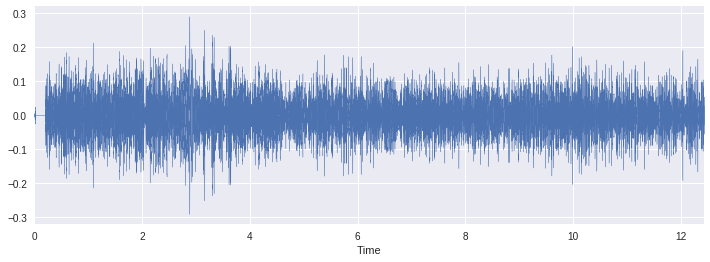

In [7]:
i = random.choice(train.index)

audio_name = train.ID[i]

path = os.path.join('drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/train/', 'Train', str(audio_name) + '.wav')

print('Class: ', train.Class[i])

x, sr = librosa.load('drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/train/Train/' + str(train.ID[i]) + '.wav')

plt.figure(figsize=(12, 4))

librosa.display.waveplot(x, sr=sr)

Let us see the class distributions for this problem

In [8]:
print(train.Class.value_counts(normalize=True)) #distribution of data

no_hambre    0.697674
hambre       0.302326
Name: Class, dtype: float64


It appears that jackhammer has more count than any other classes

Now let us see how we can leverage the concepts we learned above to solve the problem. We will follow these steps to solve the problem.

- Step 1: Load audio files & Extract features
- Step 2: Convert the data to pass it in our deep learning model
- Step 3: Run a deep learning model and get results

#### Step 1: Load audio files & Extract features

Let us create a function to load audio files and extract features

In [0]:
def parser(row):
    file_name = os.path.join(os.path.abspath('drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/train/'),'Train',str(row.ID)+'.wav')
    try:
        # here kaiser_fast is a technique used for faster extraction
        X,sample_rate = librosa.load(file_name,res_type='kaiser_fast')
        # we extract mfcc feature from data
        mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=40).T,axis=0)
    except Exception as e:
        print('Error encountered while parsing the file:',file_name)
        
        return 'None', 'None'
    feature = mfccs  
    label = row.Class
    #print(file_name)
    print(feature)
    print(label)
    return pd.Series([feature, label],index=['feature','label'])
    #return [feature,label]

In [0]:
temp = train.apply(parser,axis =1)
temp.columns = ['feature', 'label']

#### Step 2: Convert the data to pass it in our deep learning model

In [0]:
X = np.array(temp.feature.tolist())
y = np.array(temp.label.tolist())
label_encoder = LabelEncoder()
y = np_utils.to_categorical(label_encoder.fit_transform(y)) 

### Step 3: Run a deep learning model and get results

**Multilayer perceptron (MLP)**

In [257]:
num_labels = y.shape[1]
print(num_labels)

filter_size = 2


from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers


# Define the model
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=(40,))) #units=16
#model.add(Dense(16, kernel_regularizer=regularizers.l2(0.1),
#                          activation='relu', input_shape=(40,)))
#model.add(Dropout(0.5))
model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
#model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=num_labels, activation='sigmoid'))  
# Note that we do not need to indicate the input shape for the sucessives layes

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()


history = model.fit(X, y, batch_size=32, epochs=50, validation_data=(val_X, val_Y))

score = model.evaluate(val_X, val_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_154 (Dense)            (None, 16)                656       
_________________________________________________________________
dense_155 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_156 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_157 (Dense)            (None, 2)                 34        
Total params: 1,234
Trainable params: 1,234
Non-trainable params: 0
_________________________________________________________________
Train on 43 samples, validate on 25 samples
Epoch 1/50
43/43 [==============================] - 7s 161ms/step - loss: 5.1561 - acc: 0.4884 - val_loss: 1.5196 - val_acc: 0.8200
Epoch 2/50
43/43 [==============================] - 0s 298us/step - loss: 2.6028 - acc: 0.6744

**Recurrent Neuronal Networks (RNN) **

In [169]:
#simple example
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

X = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = np.array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

X = X.reshape(1,10,1)
y = y.reshape(1,10,1)

data_dim = 1
timesteps = 10

model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(timesteps, data_dim)))
model.add(LSTM(32, return_sequences=True))
model.add(Dense(1, activation='linear'))

print(model.summary())

model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])

model.fit(X,y, batch_size=1, epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 10, 32)            4352      
_________________________________________________________________
lstm_49 (LSTM)               (None, 10, 32)            8320      
_________________________________________________________________
dense_106 (Dense)            (None, 10, 1)             33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 154.5016 - acc: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 16ms/step - loss: 150.3630 - acc: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 16ms/step - loss: 147.2375 - acc: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 17ms/step - loss: 144.3478 - acc: 0.0000e+00
Epoch 5

In [225]:

from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np


X = X.reshape(43,40,1)
print(X.shape)
y = y.reshape(43,2,1)
print(y.shape)

data_dim = 1
timesteps = 40

model = Sequential()
model.add(LSTM(1, return_sequences=True, input_shape=(40, 1)))
model.add(LSTM(32, return_sequences=True))
model.add(Dense(num_labels, activation='linear'))

print(model.summary())

model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])

#model.fit(X,y, batch_size=1, epochs=10)

(43, 40, 1)
(43, 2, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_92 (LSTM)               (None, 40, 1)             12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
None


In [255]:
X= np.absolute(X)
val_X= np.absolute(val_X)


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense


model = Sequential()

max_words = 10000
embedding_size = 128 

# 1. Define and add Embedding layer to the model
model.add(Embedding(max_words, embedding_size))
# After the Embedding layer, 
# our activations have shape `(batch_size, max_seq, embedding_size)`.

# 2. Define and add LSTM layer to the model.
model.add(LSTM(128))
model.add(layers.Dropout(0.5))

# 3. Define and add Dense layer to the model
model.add(Dense(num_labels, activation='sigmoid'))

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()
history = model.fit(X, y, batch_size=32, epochs=50, validation_data=(val_X, val_Y))

score = model.evaluate(val_X, val_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 128)         1280000   
_________________________________________________________________
lstm_101 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_153 (Dense)            (None, 2)                 258       
Total params: 1,411,842
Trainable params: 1,411,842
Non-trainable params: 0
_________________________________________________________________
Train on 43 samples, validate on 25 samples
Epoch 1/50
43/43 [==============================] - 8s 181ms/step - loss: 0.6878 - acc: 0.6047 - val_loss: 0.6204 - val_acc: 0.8400
Epoch 2/50
43/43 [==============================] - 0s 4ms/step - loss: 0.6338 - acc: 0.

**Convolutional Neuronal Networks (CNN)**

In [241]:
X= np.absolute(X)
val_X= np.absolute(val_X)

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

max_words = 10000
max_seq = 40
embedding_size = 128

model = Sequential()
model.add(layers.Embedding(max_words, embedding_size, input_length=max_seq))
model.add(layers.Conv1D(32, 3,activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 3,activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_labels))

model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X, y, batch_size=32, epochs=50, validation_data=(val_X, val_Y))

score = model.evaluate(val_X, val_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 40, 128)           1280000   
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 38, 32)            12320     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 17, 32)            3104      
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 32)                0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_137 (Dense)            (None, 2)                 66        
Total para

Combining RNN and CNN

In [250]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

max_words = 10000
max_seq = 40
embedding_size = 128

model = Sequential()
model.add(layers.Embedding(max_words, embedding_size, input_length=max_seq))
model.add(layers.Conv1D(32, 3,activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.LSTM(128))  ### NO TENGO QUE PONER OTRA MAXPOOLIN DESPUES DE UNA RNN
model.add(layers.Dense(2))

model.summary()


###

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X, y,
                    epochs=20,
                    batch_size=128,
                    validation_data=(val_X, val_Y))
score = model.evaluate(val_X, val_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 40, 128)           1280000   
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 38, 32)            12320     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 19, 32)            0         
_________________________________________________________________
lstm_99 (LSTM)               (None, 128)               82432     
_________________________________________________________________
dense_148 (Dense)            (None, 2)                 258       
Total params: 1,375,010
Trainable params: 1,375,010
Non-trainable params: 0
_________________________________________________________________
Train on 43 samples, validate on 25 samples
Epoch 1/20
43/43 [==============================] - 7s 168ms/step - loss: 5.1177 - acc: 

Other Neuronal Networks with more layers


In [252]:
num_labels = y.shape[1]
print(num_labels)

filter_size = 2

#Define the model

model = Sequential()

model.add(Dense(256, input_shape=(40,)))

model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(256))

model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_labels))

model.add(Activation('softmax'))

#model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()
###

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X, y,
                    epochs=20,
                    batch_size=128,
                    validation_data=(val_X, val_Y))
score = model.evaluate(val_X, val_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 256)               10496     
_________________________________________________________________
activation_31 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_151 (Dense)            (None, 256)               65792     
_________________________________________________________________
activation_32 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_152 (Dense)            (None, 2)                 514       
________

In [0]:
num_labels = y.shape[1]
print(num_labels)

filter_size = 2

# build model

model = Sequential()

model.add(Dense(256, input_shape=(40,))) #40

model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(256))

model.add(Activation('relu'))

#model.add(Dropout(0.5))

model.add(Dense(num_labels))

model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


In [236]:
print(X)
print(y)

[[-5.34955385e+02  1.02835278e+02 -2.67685299e+01 ...  2.43739046e+00
   1.43724328e+00  2.05090942e+00]
 [-4.88604255e+02  1.22984290e+02 -1.54002719e+01 ...  2.23112271e+00
   9.89277902e-01  1.56265511e+00]
 [-4.55548668e+02  8.39696720e+01 -4.38150092e+01 ...  2.50754345e-01
   1.49820286e-01  2.93345188e+00]
 ...
 [-4.96898397e+02  8.32658945e+01 -8.91166704e+00 ...  1.21357566e-01
  -1.82556597e+00  5.16531463e-02]
 [-3.63594268e+02  5.40167631e+01 -8.13691217e+01 ...  1.09964391e+00
  -2.82312966e+00 -2.79268759e+00]
 [-4.37882800e+02  9.66084466e+01 -4.94509327e+01 ... -4.64928175e-01
   3.34539834e+00  9.20522764e+00]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0.

In [179]:
print(X.shape)


(43, 40)


In [180]:
print(y.shape)

(43, 2)


In [0]:
X = X.reshape(43,40,1)
y = y.reshape(43,2,1)

Now let us train the model

In [182]:
#setup validation set
validate = pd.read_csv('drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/test/test.csv')
def parser_Val(row):    #load files and extract features
    file_name = 'drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/test/Test/' + str(row.ID) + '.wav'
    try:
      # here kaiser_fast is a technique used for faster extraction
      val_X, sample_rate = librosa.load(file_name,res_type='kaiser_fast') 
      # we extract mfcc feature from data
      mfccs = np.mean(librosa.feature.mfcc(y=val_X, sr=sample_rate, n_mfcc=40).T,axis=0) 
    except Exception as e:
      print("Error encountered while parsing file: ", file_name)
      return None, None
    feature = mfccs
    label = row.Class
    print(file_name)
    #return [feature,label]
    return pd.Series([feature, label],index=['feature','label'])
temp_Val = validate.apply(parser_Val, axis=1)
temp_Val.columns = ['feature', 'label']
val_X = np.array(temp_Val.feature.tolist())
print(val_X)
val_Y = np.array(temp_Val.label.tolist())
print(val_Y)
lb2 = LabelEncoder()
val_Y = np_utils.to_categorical(lb2.fit_transform(val_Y))
print(val_Y)

drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/test/Test/170309184543hambre-1-0-0.wav
drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/test/Test/170309184543hambre-1-0-0.wav
drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/test/Test/17021550422hambre-1-0-0.wav
drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/test/Test/170221151654hambre-1-0-0.wav
drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/test/Test/170323200608hambre-1-0-0.wav
drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/test/Test/170326132415hablando-0-0-0.wav
drive/My Drive/CURSO_DeepLearning_for_NaturalLanguageProcessing/uc3m_dl4nlp_labs_ana/data/baby_crying/test/Test/170413084629hablando-0-0-0.wav
drive/My D

In [0]:
print(X)
print(y)

In [0]:
model.fit(X, y, batch_size=32, epochs=50, validation_data=(val_X, val_Y))

In [253]:
history = model.fit(X, y, batch_size=32, epochs=50, validation_data=(val_X, val_Y))


Train on 43 samples, validate on 25 samples
Epoch 1/50
43/43 [==============================] - 0s 618us/step - loss: 6.5320 - acc: 0.5581 - val_loss: 2.5648 - val_acc: 0.8400
Epoch 2/50
43/43 [==============================] - 0s 488us/step - loss: 5.7047 - acc: 0.6279 - val_loss: 2.5648 - val_acc: 0.8400
Epoch 3/50
43/43 [==============================] - 0s 535us/step - loss: 3.2055 - acc: 0.7907 - val_loss: 2.5648 - val_acc: 0.8400
Epoch 4/50
43/43 [==============================] - 0s 472us/step - loss: 4.6538 - acc: 0.6977 - val_loss: 2.5648 - val_acc: 0.8400
Epoch 5/50
43/43 [==============================] - 0s 468us/step - loss: 5.4844 - acc: 0.6512 - val_loss: 2.5648 - val_acc: 0.8400
Epoch 6/50
43/43 [==============================] - 0s 416us/step - loss: 5.6998 - acc: 0.6047 - val_loss: 2.5648 - val_acc: 0.8400
Epoch 7/50
43/43 [==============================] - 0s 522us/step - loss: 6.0196 - acc: 0.6047 - val_loss: 2.5648 - val_acc: 0.8400
Epoch 8/50
43/43 [==============

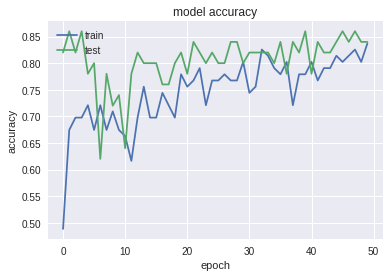

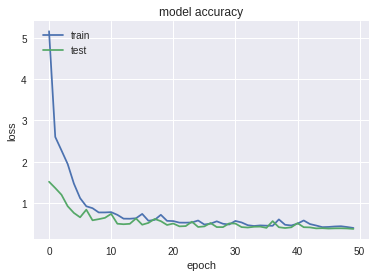

In [258]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**RESULTS**: best accuracy for RNN (0.9), MLP (0.84), CNN (0.6)



When using drop out test accuracy is better than train accuracy.
https://stackoverflow.com/questions/43979449/higher-validation-accuracy-than-training-accurracy-using-tensorflow-and-keras
